In [1]:
import numpy as np
import matplotlib.pyplot as plt
import george
import emcee
import scipy.stats


from plotting import plot_mcmc_sampling_results


In [14]:
class GPFit():
    def __init__(self, time_stamps, flux, flux_error):
        self.time = time_stamps
        self.flux = flux
        self.flux_err = flux_error
        self.data_pts = len(time_stamps)
        self.true_period = None
        self.params = None
        self.walker_params = None
        self.gp = None
        
    def set_params(self):
        """Calculates initial gp parameter values based on data."""
        mean_flux = np.mean(self.flux)
        log_amp = np.log(self.flux.max()-self.flux.min())
        gamma = 1
        log_period = 0
        
        parameters = {"mean": mean_flux, "log_amp": log_amp, "gamma": gamma,"log_period": log_period}
        self.params = parameters
        return
        
        
    def set_walker_param_matrix(self, nwalkers):
        """Creates a matrix of starting parameters for every walker."""
        
        if self.params is not None: 
            
            p_start = np.array(list(self.params.values()))
            cov_matrix = np.sqrt(np.diag(p_start)**2)
            p0 = np.random.multivariate_normal(mean=p_start, cov=cov_matrix, size=(nwalkers))
    
            # equally distributed starting period values
            p0[:,3] = np.log(np.linspace(2,12,nwalkers)/24.)
        
            self.walker_params = p0
            
        else: 
            print("Please set parameter values first.")

        return
    
    def get_gp_kernel(self):
        """Sets up the Gaussian Process Kernel that is needed for george."""
        
        kernel = np.exp(self.params["log_amp"]) * george.kernels.ExpSine2Kernel(gamma = self.params["gamma"], log_period = self.params["log_period"])
        gp = george.GP(kernel, fit_mean=True, mean=self.params["mean"])
        gp.compute(self.time, self.flux_err)
        
        self.gp = gp
        
        return gp
    
    def run_emcee(self, nwalkers, niter, threads=1):
        """Runs emcee's mcmc code."""
        
        ndim = 4        
        sampler = emcee.EnsembleSampler(nwalkers, ndim, post_lnlikelihood, args=[self.gp, self.time, self.flux, self.flux_err], threads=threads)

        mcmc_sampling = sampler.run_mcmc(self.walker_params, niter)
        
        return sampler
    
    
    
    


In [71]:
time = np.linspace(0, 1, 50)
flux = np.linspace(14, 14, 50)
flux_err = np.ones(50)*0.1

In [72]:
x = np.sin(time*20)
flux = flux + x

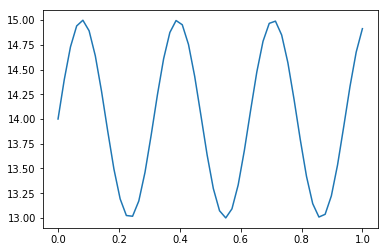

In [73]:
plt.plot(time, flux)

In [74]:
asteroid = GPFit(time, flux, flux_err)

In [75]:
asteroid.set_params()

In [79]:
asteroid.set_walker_param_matrix(10)

In [80]:
asteroid.get_gp_kernel()

In [83]:
sampler = asteroid.run_emcee(niter=10000, nwalkers=10, threads=1)

/home/christina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/home/christina/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/christina/anaconda3/lib/python3.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


In [12]:
def prior(params):

    """
    Calculated the log of the prior values, given parameter values.

    Parameters
    ----------
    params : list
        List of all kernel parameters

    param[0] : float
        mean (between 0 and 2)

    param[1] : float
        log amplitude (between -10 and 10)

    param[2] : float
        gamma (log gamma between 0.1 and 40)

    param[3] : float
        log period (period between 1h and 24hrs)

    Returns
    -------
    sum_log_prior : int
        sum of all log priors (-inf if a parameter is out of range)

    """

    p_mean = scipy.stats.norm(1, 0.5).logpdf(params[0])
    p_log_amp = scipy.stats.norm(np.log(0.15), np.log(2)).logpdf(params[1])
    p_log_gamma = scipy.stats.norm(np.log(10), np.log(2)).logpdf(np.log(params[2]))
    p_log_period = scipy.stats.norm(np.log(4./24.), (12./24.)).logpdf(params[3])

    sum_log_prior =  p_mean + p_log_amp + p_log_gamma + p_log_period

    if np.isnan(sum_log_prior) == True:
        return -np.inf

    return sum_log_prior


def logl(params, gp, tsample, fsample, flux_err):
     # compute lnlikelihood based on given parameters
     gp.set_parameter_vector(params)


     try:
         gp.compute(tsample, flux_err)
         lnlike = gp.lnlikelihood(fsample)
     except np.linalg.LinAlgError:
         lnlike = -1e25

     return lnlike


def post_lnlikelihood(params, gp, tsample, fsample, flux_err):

    """
    Calculates the posterior likelihood from the log prior and
    log likelihood.

    Parameters
    ----------
    params : list
        List of all kernel parameters

    Returns
    -------
    ln_likelihood : float
        The posterior, unless the posterior is infinite, in which case,
        -1e25 will be returned instead.

    """

    # calculate the log_prior
    log_prior = prior(params)

    # return -inf if parameters are outside the priors
    if np.isneginf(log_prior) == True:
        return -np.inf

    try:
        lnlike = logl(params, gp, tsample, fsample, flux_err)
        ln_likelihood = lnlike+log_prior

    except np.linalg.linalg.LinAlgError:
        ln_likelihood = -1e25

    return ln_likelihood if np.isfinite(ln_likelihood) else -1e25


[ 2.15826616  2.17476677  0.16926173 -1.15997059]
[ 1.86256616  2.16175776  0.45259221 -1.16405666]
[ 1.68380462  2.14350858  0.49347735 -1.15725028]
[ 1.37051794  2.61972943  0.20121028 -1.15074771]
[ 1.98968071  2.02795688  0.67204567 -0.4610028 ]
[ 2.00112721  1.98043641  0.544542   -1.15643238]
[ 1.56397802  2.31764767  0.56894045 -1.15580425]
[ 1.02110218  2.16338439  0.33884178 -1.15807309]
[ 1.62797012  2.0861855   0.82418107 -0.46473146]
[ 1.20758795  2.12181156  0.22483557 -1.1490844 ]


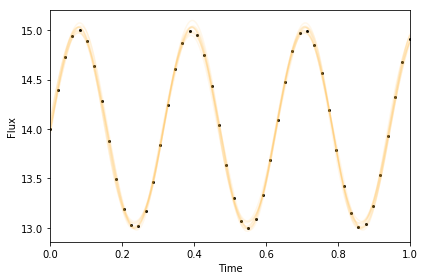

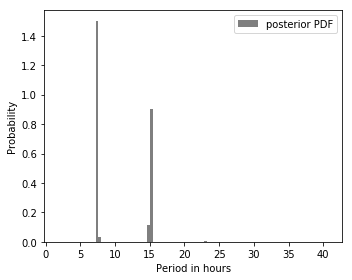

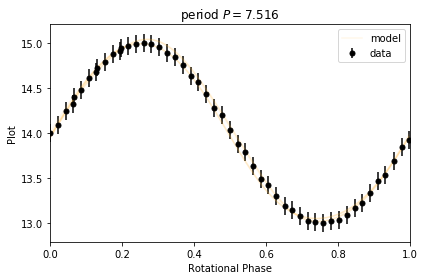

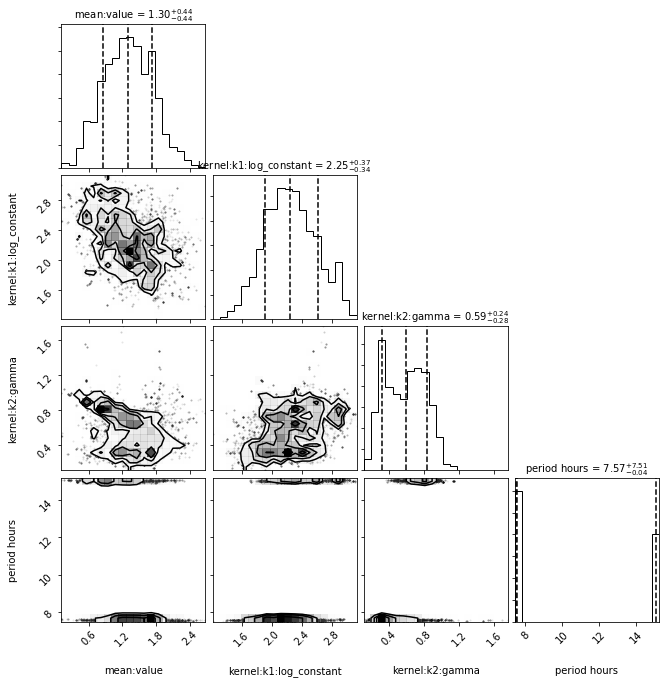

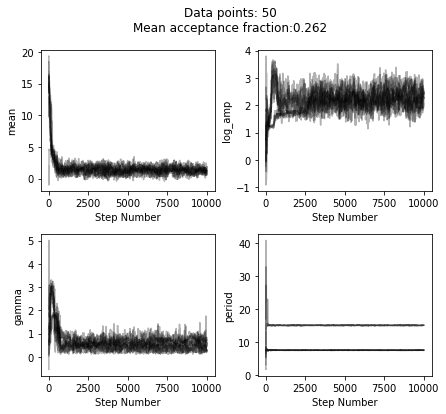

In [84]:
plot_mcmc_sampling_results(asteroid.time, asteroid.flux, asteroid.flux_err, asteroid.gp, sampler, namestr=filename + "_plots", true_period=None)

In [17]:
filename = "test_obj_orient"